In [1]:
%pip install pulp          # 최적화 모델링
%pip install numpy         # 수치 계산
%pip install scipy         # 과학 계산
%pip install matplotlib    # 시각화
%pip install geopandas     # 공간 데이터 처리

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import pulp
import matplotlib.pyplot as plt
from pyproj import Transformer
from matplotlib.patches import Patch


In [3]:
# 한글 폰트 설정

# windows 폰트 설정
# import matplotlib.pyplot as plt
# plt.rc('font', family='Malgun Gothic')  # 맑은 고딕 사용
# plt.rcParams['axes.unicode_minus'] = False

# mac 폰트 설정
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')  # 애플고딕 사용
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 좌표계 변환기 생성
# 시각화를 위한

trans = Transformer.from_crs("epsg:4326", "epsg:5179", always_xy=True)

In [5]:
# 1. 데이터 불러오기 함수 (좌표 값(x,y))

# 수요지
def load_data(route):
    df = pd.read_csv(route)
    x, y = trans.transform(df['_X'].values, df['_Y'].values)
    return np.column_stack([x, y]), df['val'].values

# 기존 카페, 후보지
def load_coord(route):
    df = pd.read_csv(route)
    x, y = trans.transform(df['_X'].values, df['_Y'].values)
    return np.column_stack([x, y])

In [6]:
# 2. 데이터 불러오기

demand_coords, demand_weights = load_data('demand_data.csv')
candidate_coords = load_coord('candidate_data.csv')
existing_coords = load_coord('kidscafes.csv')

In [7]:
# 3. MCLP 함수 (Pulp 라이브러리 사용)

def mclp(demand_coords, demand_weights, candidate_coords, 
                   num_facilities, service_radius, existing_coords=None, 
                   min_distance=0):
    existing_cover = np.zeros(len(demand_coords), dtype=bool)
    if existing_coords is not None and len(existing_coords) > 0:
        dist_ex = distance_matrix(demand_coords, existing_coords)
        existing_cover = (dist_ex <= service_radius).any(axis=1)
    
    yes_candidate = candidate_coords.copy()
    if existing_coords is not None and min_distance > 0:
        dist_to_ex = distance_matrix(candidate_coords, existing_coords)
        yes_mask = np.all(dist_to_ex >= min_distance, axis=1)
        yes_candidate = candidate_coords[yes_mask]
    
    model_MCLP = pulp.LpProblem("MCLP", pulp.LpMaximize)
    dist_matrix = distance_matrix(demand_coords, yes_candidate)
    coverage = (dist_matrix <= service_radius).astype(int)

    x = pulp.LpVariable.dicts("x", range(len(yes_candidate)), cat='Binary')
    y = pulp.LpVariable.dicts("y", range(len(demand_coords)), cat='Binary')

    model_MCLP += pulp.lpSum(y[i] * demand_weights[i] * (1 - existing_cover[i]) for i in range(len(demand_coords)))
    model_MCLP += pulp.lpSum(x) == num_facilities
    for i in range(len(demand_coords)):
        model_MCLP += y[i] <= pulp.lpSum(x[j] * coverage[i, j] for j in range(len(yes_candidate)))

    model_MCLP.solve(pulp.PULP_CBC_CMD(msg=False))
    select = [j for j in range(len(yes_candidate)) if x[j].varValue == 1]
    selected_sites = yes_candidate[select]
    
    new_cover = np.zeros(len(demand_coords), dtype=bool)
    if len(selected_sites) > 0:
        dist_new = distance_matrix(demand_coords, selected_sites)
        new_cover = (dist_new <= service_radius).any(axis=1)
    
    total_cover = existing_cover | new_cover
    total_possible = np.sum(demand_weights)
    existing_weight = np.sum(demand_weights[existing_cover])
    new_weight = np.sum(demand_weights[new_cover & ~existing_cover])
    total_weight = existing_weight + new_weight

    return selected_sites, existing_weight, new_weight, total_weight, total_possible


In [8]:
def visual1(demand_coords, demand_weights, candidate_coords, 
                     existing_coords, selected_sites, service_radius,
                     existing_weight, new_weight, total_weight, total_possible):
    
    plt.figure(figsize=(10, 8))
    
    # 수요지 색상/크기 설정
    plt.scatter(demand_coords[:,0], demand_coords[:,1], 
                c=demand_weights, cmap='YlOrRd', alpha=0.6, s=50,
                label=f'수요지 ({len(demand_coords)}개)')
    gradient_bar = plt.colorbar(label='유아 인구 수')
    gradient_bar.set_label('유아 인구 수', rotation=270, labelpad=15)
    
    # 후보지
    plt.scatter(candidate_coords[:,0], candidate_coords[:,1], 
                c='blue', marker='x', label=f'후보지 ({len(candidate_coords)}개)')
    
    # 기존 시설
    if existing_coords is not None:
        plt.scatter(existing_coords[:,0], existing_coords[:,1],
                    c='purple', s=150, marker='s', 
                    label=f'기존 시설 ({len(existing_coords)}개)')
        for site in existing_coords:
            plt.gca().add_patch(plt.Circle(
                site, service_radius, color='purple', fill=False, alpha=0.2))
    
    # 선정 시설
    plt.scatter(selected_sites[:,0], selected_sites[:,1],
                c='green', s=200, edgecolor='black', 
                label=f'선정 시설 ({len(selected_sites)}개)')
    for site in selected_sites:
        plt.gca().add_patch(plt.Circle(
            site, service_radius, color='green', fill=False, linestyle='--'))
    
    # 커버 상태 범례
    legend_elements = [
        Patch(facecolor='orange', label=f'기존 커버: {existing_weight:.0f}명'),
        Patch(facecolor='lime', label=f'신규 커버: {new_weight:.0f}명'),
        Patch(facecolor='red', label=f'미커버: {total_possible-total_weight:.0f}명')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title(f'서울형 키즈카페 입지 분석 (총 커버리지: {total_weight/total_possible*100:.1f}%)')
    plt.xlabel('UTM-K X (m)')
    plt.ylabel('UTM-K Y (m)')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

In [9]:
def visual2(demand_coords, demand_weights, candidate_coords, 
                     existing_coords, selected_sites, service_radius,
                     existing_weight, new_weight, total_weight, total_possible):
    
    plt.figure(figsize=(9, 7))
    
    # 수요지 
    scatter1 = plt.scatter(demand_coords[:,0], demand_coords[:,1], 
    c=demand_weights, cmap='Reds', alpha=0.8, s=40,  # alpha 0.6→0.8, size 30→40
    edgecolors='darkred', linewidth=0.3,  # 테두리 추가
    label=f'수요지 ({len(demand_coords)}개)')

    gradient_bar = plt.colorbar(scatter1, shrink=0.8)
    gradient_bar.set_label('유아 인구 수', rotation=270, labelpad=15)
    
    # 후보지
    plt.scatter(candidate_coords[:,0], candidate_coords[:,1], 
                c='dodgerblue', marker='^', s=60, alpha=0.7, edgecolor='navy',
                label=f'후보지 ({len(candidate_coords)}개)')
    
    # 신규 선정 시설
    plt.scatter(selected_sites[:,0], selected_sites[:,1],
                c='limegreen', s=250, marker='o', edgecolor='darkgreen', linewidth=2,
                label=f'선정 시설 ({len(selected_sites)}개)')
    
    # 범례 추가
    plt.legend(loc='upper left', fontsize=11, frameon=True, 
               fancybox=True, shadow=True, bbox_to_anchor=(0, 1))
    

    plt.title(f'서울형 키즈카페 입지 분석')
    plt.xlabel('UTM-K X (m)')
    plt.ylabel('UTM-K Y (m)')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()


In [10]:
# 5. 실행
selected_sites, existing_weight, new_weight, total_weight, total_possible = mclp(
    demand_coords, demand_weights, candidate_coords,
    num_facilities=3,
    service_radius=700,
    existing_coords=existing_coords,
    min_distance=0
)

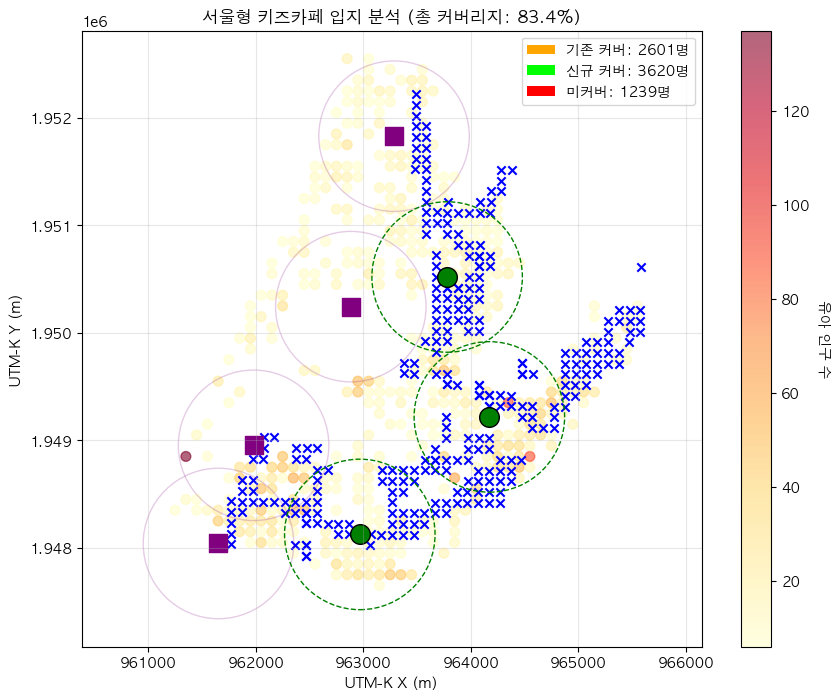

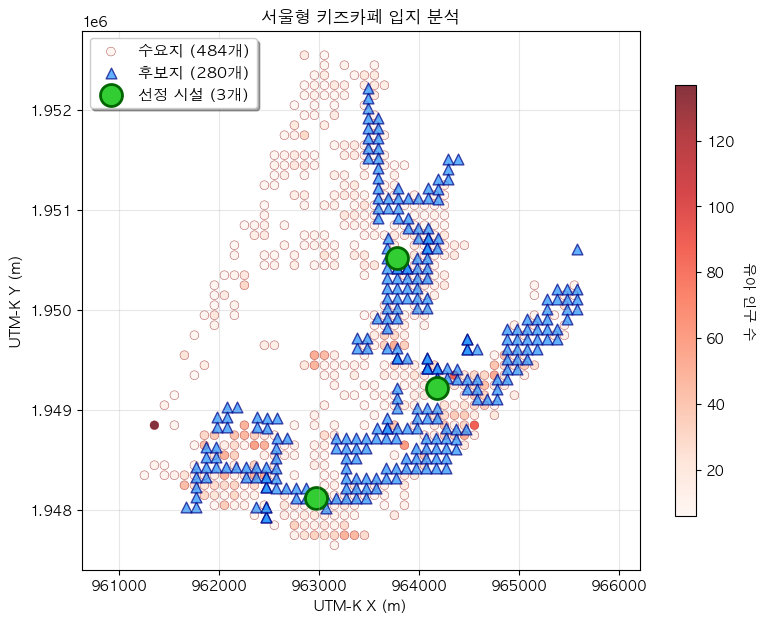

In [11]:
# 6. 시각화 (결과분석용 + 신규시설 위치 확인용)
visual1(
    demand_coords, demand_weights, candidate_coords,
    existing_coords, selected_sites, 700,
    existing_weight, new_weight, total_weight, total_possible
)

visual2(
    demand_coords, demand_weights, candidate_coords,
    existing_coords, selected_sites, 700,
    existing_weight, new_weight, total_weight, total_possible
)

In [12]:
# 7. 통계 확인

print(f"전체 유아 인구: {total_possible:.0f}명")
print(f"기존 시설 커버: {existing_weight:.0f}명 ({existing_weight/total_possible*100:.1f}%)")
print(f"신규 추가 커버: {new_weight:.0f}명 ({new_weight/total_possible*100:.1f}%)")
print(f"총 커버리지: {total_weight:.0f}명 ({total_weight/total_possible*100:.1f}%)")
print(f"미커버: {total_possible-total_weight:.0f}명 ({(total_possible-total_weight)/total_possible*100:.1f}%)")

전체 유아 인구: 7460명
기존 시설 커버: 2601명 (34.9%)
신규 추가 커버: 3620명 (48.5%)
총 커버리지: 6221명 (83.4%)
미커버: 1239명 (16.6%)


In [13]:
# 신규 시설 입지 좌표 출력

print("선정된 입지")
for idx, (x, y) in enumerate(selected_sites, 1):
    print(f"X={x:.2f}, Y={y:.2f}")

선정된 입지
X=963780.15, Y=1950519.49
X=964173.08, Y=1949217.88
X=962967.71, Y=1948124.69
